### Домашнее задание №2

#### 1. Самостоятельно разобраться с тем, что такое tf-idf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

#### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

##### 2.1. Авторский вариант кода

In [551]:
import pandas as pd
import re
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

Наши новости

In [552]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [553]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [554]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [555]:
#предобработка текстов
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\60053972\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [556]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

c:\Users\60053972\Anaconda3\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
c:\Users\60053972\Anaconda3\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
c:\Users\60053972\Anaconda3\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
c:\Users\60053972\Anaconda3\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, vara

In [557]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

779

In [558]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

<>:13: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
C:\Users\60053972\AppData\Local\Temp/ipykernel_21580/3066725202.py:13: DeprecationWarning: invalid escape sequence \s
  text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))


In [559]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 23.5 s


In [560]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 4min 7s


In [561]:
# Сохраним лемматизированный текст в файл, чтобы какжды раз не жджать при запуске кода
news['title'].to_csv("materials_lem.csv", index=False)
news['title_2'] = pd.read_csv("materials_lem.csv")

А теперь в 3 строчки обучим нашу модель

In [562]:
#сформируем список списков наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [617]:
common_dictionary.token2id

{'александр': 0,
 'алексей': 1,
 'андрей': 2,
 'армеец': 3,
 'банк': 4,
 'баскетбол': 5,
 'близкий': 6,
 'блок': 7,
 'борьба': 8,
 'ватутин': 9,
 'взаимодействие': 10,
 'власть': 11,
 'войти': 12,
 'вячеслав': 13,
 'генералполковник': 14,
 'генеральный': 15,
 'георгий': 16,
 'гмк': 17,
 'директор': 18,
 'европа': 19,
 'единогласно': 20,
 'заместитель': 21,
 'заседание': 22,
 'защита': 23,
 'иванов': 24,
 'избрать': 25,
 'исакович': 26,
 'клиентский': 27,
 'клуб': 28,
 'конституционный': 29,
 'корпоративный': 30,
 'леонид': 31,
 'лопат': 32,
 'министр': 33,
 'мир': 34,
 'начальник': 35,
 'никель': 36,
 'новак': 37,
 'норильский': 38,
 'оао': 39,
 'обсуждение': 40,
 'округ': 41,
 'ольга': 42,
 'ооо': 43,
 'орган': 44,
 'основной': 45,
 'пбк': 46,
 'первый': 47,
 'перспектива': 48,
 'планирование': 49,
 'плешаков': 50,
 'политика': 51,
 'полномочный': 52,
 'полтавец': 53,
 'полтавченко': 54,
 'правительство': 55,
 'правление': 56,
 'председатель': 57,
 'представитель': 58,
 'президент': 5

Все просто - это словарь наших слов

Запускаем обучение

In [564]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 36.9 s


In [565]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [566]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.0734528), (11, 0.443552), (14, 0.28012896), (18, 0.1841036)]

In [567]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: собственность заведение учебный рыночный лестница деловой шутка
topic_1: это год который страна россия глава президент
topic_2: район пострадать космос рейс авария автомобиль местный
topic_3: научный двигатель дональд сигнал это ск небо
topic_4: сша фонд американский который проект запуск год
topic_5: выяснить взрыв город армия произойти территория находиться
topic_6: римский корзина папа жуковский хорватия ильин армянин
topic_7: год который россия это российский мочь система
topic_8: продукция оборудование методика вдвое адмирал инженер потребность
topic_9: год украина это гражданин украинский который население
topic_10: млрд реконструкция нил югра кот аудитория гвоздь
topic_11: год который это исследование свой человек работа
topic_12: мозг напомнить погибнуть остров обнаружить офицер ступень
topic_13: экономика компания экономический производитель который бизнес политика
topic_14: это который всё человек мочь весь земля
topic_15: налог индия платёжный браун орудие алтай мил

Очень неплохо - большинство тем вполне можно описать о чем они

In [568]:
# Визуализируем результаты
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda, common_corpus, common_dictionary)
pyLDAvis.save_html(vis_data, "vis_data.html")
pyLDAvis.display(vis_data)

c:\Users\60053972\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [569]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [570]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.296433,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.316926,0.018035,0.0,0.02863,0.0,0.0,0.000000,0.0
1,4896,0.0,0.000000,0.000000,0.000000,0.000000,0.685554,0.0,0.0,0.0,...,0.0,0.0,0.065483,0.226957,0.0,0.00000,0.0,0.0,0.000000,0.0
2,4897,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.196683,0.0,0.00000,0.0,0.0,0.000000,0.0
3,4898,0.0,0.000000,0.015566,0.077104,0.044245,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.034329,0.123828,0.0,0.00000,0.0,0.0,0.000000,0.0
4,4899,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.973277,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [571]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [572]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [573]:
doc_dict[293622]

array([0.        , 0.        , 0.02468191, 0.1349432 , 0.        ,
       0.04958124, 0.        , 0.        , 0.03311851, 0.        ,
       0.        , 0.25160867, 0.        , 0.        , 0.        ,
       0.        , 0.11193801, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1114779 , 0.        , 0.27217087])

In [574]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [575]:
user_articles_list

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [576]:
get_user_embedding(user_articles_list)

array([0.        , 0.2072945 , 0.        , 0.0033579 , 0.04137139,
       0.01309124, 0.        , 0.09685527, 0.        , 0.03634001,
       0.        , 0.10278885, 0.00394436, 0.        , 0.02042148,
       0.        , 0.03499002, 0.04811748, 0.        , 0.        ,
       0.00377362, 0.06684703, 0.00178245, 0.01544729, 0.29310541])

Не так: Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [577]:
#users['articles'].iloc[33]

In [578]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [579]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.006221,0.083256,0.036123,0.022491,0.021993,0.031485,0.0,0.075411,0.012688,...,0.007845,0.028009,0.000000,0.00000,0.000000,0.006754,0.018263,0.075779,0.010607,0.134539
1,u108690,0.000000,0.176102,0.015736,0.000000,0.057725,0.016085,0.0,0.065205,0.000000,...,0.007533,0.047413,0.031008,0.00000,0.000000,0.000000,0.043715,0.010177,0.034158,0.159105
2,u108339,0.000000,0.189916,0.070133,0.023787,0.013258,0.065210,0.0,0.042258,0.000000,...,0.000000,0.004155,0.062527,0.00358,0.001736,0.000000,0.056808,0.047425,0.036625,0.197597


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [580]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [581]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.006221,0.083256,0.036123,0.022491,0.021993,0.031485,0.0,0.075411,0.012688,...,0.028009,0.000000,0.00000,0.000000,0.006754,0.018263,0.075779,0.010607,0.134539,0
1,u108690,0.000000,0.176102,0.015736,0.000000,0.057725,0.016085,0.0,0.065205,0.000000,...,0.047413,0.031008,0.00000,0.000000,0.000000,0.043715,0.010177,0.034158,0.159105,1
2,u108339,0.000000,0.189916,0.070133,0.023787,0.013258,0.065210,0.0,0.042258,0.000000,...,0.004155,0.062527,0.00358,0.001736,0.000000,0.056808,0.047425,0.036625,0.197597,1


In [582]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [583]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [584]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [585]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10084945, 0.02288166, 0.24237812, 0.16947317, 0.08742942,
       0.12457229, 0.17502919, 0.25340603, 0.09876663, 0.05622784])

In [586]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [589]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.242378, F-Score=0.665, Precision=0.632, Recall=0.702


In [590]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1655  100]
 [  74  171]]


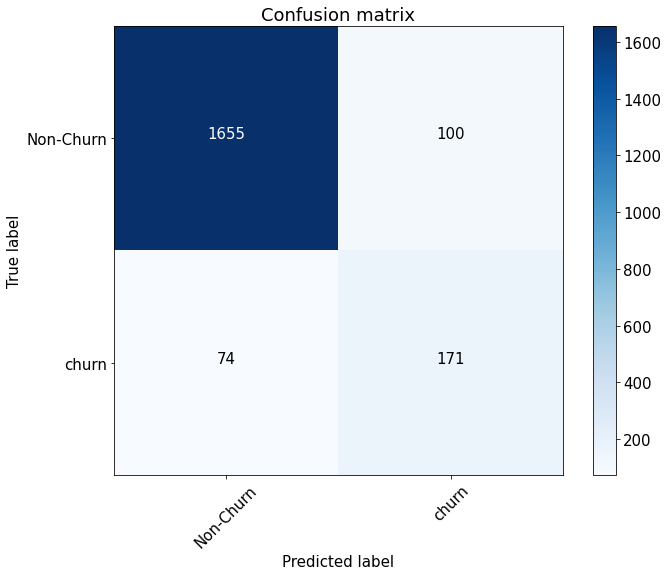

In [591]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [592]:
roc_auc_score(y_test, preds)

0.9475411361125647

In [593]:
# Запишем метрики с median в словарь
metrics = {
    'Variant': [
    'mean', 
    # 'median', 
    # 'max', 
    # 'idf_mean'
    ],
    'roc_auc': [roc_auc_score(y_test, preds)],
    'precision': [precision[ix]],
    'recall': [recall[ix]],
    'f_score': [fscore[ix]]
     } 

##### 2.2. Вариант функции get_user_embedding с медианой

In [594]:

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [595]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.072805,0.012341,0.000000,0.000000,0.000000,0.0,0.045048,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.017316
1,u108690,0.0,0.160321,0.000000,0.000000,0.005117,0.010179,0.0,0.000000,0.0,...,0.0,0.014134,0.008265,0.0,0.0,0.0,0.005122,0.000000,0.016153,0.167278
2,u108339,0.0,0.206419,0.080013,0.020253,0.000000,0.015442,0.0,0.047882,0.0,...,0.0,0.000000,0.035735,0.0,0.0,0.0,0.054227,0.024435,0.028228,0.181068


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [596]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [597]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.072805,0.012341,0.000000,0.000000,0.000000,0.0,0.045048,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.017316,0
1,u108690,0.0,0.160321,0.000000,0.000000,0.005117,0.010179,0.0,0.000000,0.0,...,0.014134,0.008265,0.0,0.0,0.0,0.005122,0.000000,0.016153,0.167278,1
2,u108339,0.0,0.206419,0.080013,0.020253,0.000000,0.015442,0.0,0.047882,0.0,...,0.000000,0.035735,0.0,0.0,0.0,0.054227,0.024435,0.028228,0.181068,1


In [598]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [599]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [600]:
#наши прогнозы для тестовой выборки
preds_median = logreg.predict_proba(X_test)[:, 1]
preds_median[:10]

array([0.1165618 , 0.03351421, 0.20185733, 0.281948  , 0.05172952,
       0.0357305 , 0.16677677, 0.29657079, 0.05244236, 0.11410464])

### Рассчитаем Precision, Recall, F_score

In [601]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))

Best Threshold=0.253214, F-Score=0.741, Precision=0.719, Recall=0.763


In [506]:
roc_auc_score(y_test, preds_median)

0.9548369091226233

In [507]:
# Запишем метрики с median в словарь
metrics = {
    'Variant': [
    'mean', 
    'median', 
    # 'max', 
    # 'idf_mean'
    ],
    'roc_auc': [roc_auc_score(y_test, preds), roc_auc_score(y_test, preds_median)],
    'precision': [precision[ix], precision_median[ix_median]],
    'recall': [recall[ix], recall_median[ix_median]],
    'f_score': [fscore[ix], fscore_median[ix_median]]
     } 

metrics_df = pd.DataFrame(metrics) 

#### 3. Повторить п.2, но используя уже не медиану, а max

In [508]:

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [509]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.347763,0.0,0.0,0.214506,0.041724,0.208750,0.326123,0.000000,...,0.025928,0.368811,0.247452,0.042113,0.039802,0.0,0.000000,0.116431,0.265176,0.284459
1,u108690,0.026555,0.090752,0.0,0.0,0.052697,0.033028,0.349140,0.040536,0.000000,...,0.031502,0.341707,0.191701,0.000000,0.000000,0.0,0.010809,0.035287,0.227036,0.157044
2,u108339,0.088929,0.140056,0.0,0.0,0.123771,0.031166,0.241419,0.064718,0.010962,...,0.095956,0.258263,0.321425,0.000000,0.015129,0.0,0.000000,0.057894,0.089913,0.131269


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [510]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [511]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.347763,0.0,0.0,0.214506,0.041724,0.208750,0.326123,0.000000,...,0.368811,0.247452,0.042113,0.039802,0.0,0.000000,0.116431,0.265176,0.284459,0
1,u108690,0.026555,0.090752,0.0,0.0,0.052697,0.033028,0.349140,0.040536,0.000000,...,0.341707,0.191701,0.000000,0.000000,0.0,0.010809,0.035287,0.227036,0.157044,1
2,u108339,0.088929,0.140056,0.0,0.0,0.123771,0.031166,0.241419,0.064718,0.010962,...,0.258263,0.321425,0.000000,0.015129,0.0,0.000000,0.057894,0.089913,0.131269,1


In [512]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [513]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [514]:
#наши прогнозы для тестовой выборки
preds_max = logreg.predict_proba(X_test)[:, 1]
preds_max[:10]

array([0.07127265, 0.08374903, 0.80581811, 0.21636242, 0.13055214,
       0.02327748, 0.02288935, 0.09956461, 0.05952552, 0.32402301])

### Рассчитаем Precision, Recall, F_score

In [515]:
precision_max, recall_max, thresholds_max= precision_recall_curve(y_test, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

Best Threshold=0.342108, F-Score=0.771, Precision=0.787, Recall=0.755


In [516]:
roc_auc_score(y_test, preds_max)

0.965079365079365

In [517]:
# Запишем метрики с median в словарь
metrics = {
    'Variant': [
    'mean', 
    'median', 
    'max', 
    # 'idf_mean'
    ],
    'roc_auc': [roc_auc_score(y_test, preds), roc_auc_score(y_test, preds_median), roc_auc_score(y_test, preds_max)],
    'precision': [precision[ix], precision_median[ix_median], precision_max[ix_max]],
    'recall': [recall[ix], recall_median[ix_median], recall_max[ix_max]],
    'f_score': [fscore[ix], fscore_median[ix_median], fscore_max[ix_max]]
     } 

metrics_df = pd.DataFrame(metrics) 

#### 4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tf-idf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [518]:
# Создадим матрицу статей
docs_2 = users.articles.values
docs_2

array(['[293672, 293328, 293001, 293622, 293126, 1852]',
       '[3405, 1739, 2972, 1158, 1599, 322665]',
       '[1845, 2009, 2356, 1424, 2939, 323389]', ...,
       '[322811, 323898, 321858, 323345, 323491, 2193]',
       '[5436, 6092, 6891, 7045, 5320, 487379]',
       '[294096, 293759, 294178, 293544, 293921, 2909]'], dtype=object)

In [521]:
cv=CountVectorizer() 
# этот шаг генерирует количество слов для слов в каждой новости
word_count_vector_2=cv.fit_transform(docs_2)

In [607]:
# Помсотрим на эту матрицу
word_count_vector_2.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [524]:
# Посмотрим на размер матрицы
word_count_vector_2.shape

(8000, 14781)

In [525]:
cv.get_feature_names_out()

array(['10', '100', '1000', ..., '997', '998', '999'], dtype=object)

In [526]:
# Определим idf для каждой статьи
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector_2)

TfidfTransformer()

In [527]:
# Посмотрим на вес каждой статьи
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])  
df_idf.sort_values(by=['idf_weights'])

c:\Users\60053972\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
321929,7.096950
323233,7.096950
324181,7.096950
321850,7.096950
323631,7.154108
...,...
513087,9.294175
513085,9.294175
513083,9.294175
513094,9.294175


In [528]:
# Создадим словарь номерстатьи: ее вес
df_idf_dict = df_idf.to_dict()['idf_weights']
df_idf_dict

{'10': 8.888709524182016,
 '100': 7.9078802711702885,
 '1000': 8.041411663794811,
 '1001': 8.888709524182016,
 '1002': 8.888709524182016,
 '1003': 8.041411663794811,
 '1005': 8.601027451730232,
 '1006': 9.29417463229018,
 '1007': 9.29417463229018,
 '1008': 9.29417463229018,
 '1009': 8.888709524182016,
 '101': 7.589426540051753,
 '1010': 8.601027451730232,
 '1011': 9.29417463229018,
 '1012': 8.377883900416023,
 '1013': 8.888709524182016,
 '1014': 8.888709524182016,
 '1015': 9.29417463229018,
 '1016': 8.888709524182016,
 '1017': 8.888709524182016,
 '1018': 8.888709524182016,
 '1019': 8.377883900416023,
 '102': 7.9078802711702885,
 '1020': 8.888709524182016,
 '1021': 9.29417463229018,
 '1022': 9.29417463229018,
 '1023': 8.601027451730232,
 '1024': 9.29417463229018,
 '1025': 8.888709524182016,
 '1026': 8.888709524182016,
 '1027': 8.888709524182016,
 '1028': 8.888709524182016,
 '103': 7.9078802711702885,
 '1030': 8.601027451730232,
 '1031': 8.377883900416023,
 '1032': 8.377883900416023,
 '1

In [536]:
# Этих статей нет в словаре. Создадим их со средним весом
df_idf_dict['7'] = mean(df_idf_dict[k] for k in df_idf_dict)
df_idf_dict['4'] = mean(df_idf_dict[k] for k in df_idf_dict)
df_idf_dict['5'] = mean(df_idf_dict[k] for k in df_idf_dict)
df_idf_dict['6'] = mean(df_idf_dict[k] for k in df_idf_dict)
df_idf_dict['9'] = mean(df_idf_dict[k] for k in df_idf_dict)
df_idf_dict['2'] = mean(df_idf_dict[k] for k in df_idf_dict)

In [540]:
# Перепишем функцию с медианой. Для этого умножим вектор каждой новости на ее вес
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([(doc_dict[doc_id] * df_idf_dict[str(doc_id)]) for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [541]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

[293672, 293328, 293001, 293622, 293126, 1852]
[3405, 1739, 2972, 1158, 1599, 322665]
[1845, 2009, 2356, 1424, 2939, 323389]
[5933, 6186, 5055, 6977, 5206, 488389]
[707, 1144, 2532, 2928, 3133, 324592]
[323868, 323426, 324267, 322426, 324104, 1550]
[293138, 294471, 295012, 294736, 293949, 3544]
[6928, 5009, 6940, 7629, 7644, 512736]
[322838, 324699, 322991, 322120, 324327, 472331]
[7827, 6427, 7394, 7151, 6335, 487254]
[322147, 322974, 322922, 74, 322665, 472624]
[6163, 7517, 6678, 7482, 5124, 511479]
[323041, 322782, 322341, 323296, 324213, 473474]
[293610, 293254, 294722, 290157, 294206, 3333]
[324642, 324210, 322657, 323620, 43, 473393]
[1815, 881, 2707, 908, 1991, 324591]
[324558, 324474, 322456, 321907, 324207, 473417]
[6496, 5702, 6539, 4975, 6478, 488381]
[33, 323960, 323752, 322762, 323119, 473084]
[323805, 321846, 322203, 322049, 322512, 471812]
[3467, 1761, 3074, 3055, 1135, 322136]
[1680, 635, 2971, 3350, 1326, 322982]
[324361, 323745, 323278, 324106, 323324, 1877]
[323368, 

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.173018,0.0,0.0,0.000000,0.0,0.473215,1.183051,0.0,...,0.000000,0.000000,0.366594,0.0,0.0,0.0,0.0,0.121387,0.071490,0.800844
1,u108690,0.0,0.338500,0.0,0.0,0.000000,0.0,0.363196,0.000000,0.0,...,0.000000,2.136445,0.920682,0.0,0.0,0.0,0.0,0.045345,0.313249,0.591569
2,u108339,0.0,0.239485,0.0,0.0,0.480406,0.0,1.104522,0.243140,0.0,...,0.365826,1.201944,0.958204,0.0,0.0,0.0,0.0,0.000000,0.329419,0.799250


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [542]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [543]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.173018,0.0,0.0,0.000000,0.0,0.473215,1.183051,0.0,...,0.000000,0.366594,0.0,0.0,0.0,0.0,0.121387,0.071490,0.800844,0
1,u108690,0.0,0.338500,0.0,0.0,0.000000,0.0,0.363196,0.000000,0.0,...,2.136445,0.920682,0.0,0.0,0.0,0.0,0.045345,0.313249,0.591569,1
2,u108339,0.0,0.239485,0.0,0.0,0.480406,0.0,1.104522,0.243140,0.0,...,1.201944,0.958204,0.0,0.0,0.0,0.0,0.000000,0.329419,0.799250,1


In [544]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [545]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [546]:
#наши прогнозы для тестовой выборки
preds_idf_median = logreg.predict_proba(X_test)[:, 1]
preds_idf_median[:10]

array([2.39533443e-02, 3.63279456e-03, 9.93087090e-01, 1.21743963e-01,
       4.83166849e-04, 2.34137350e-03, 1.76614412e-02, 1.29286550e-02,
       2.64276990e-01, 6.49990667e-01])

### Рассчитаем Precision, Recall, F_score

In [547]:
precision_idf_median, recall_idf_median, thresholds_idf_median = precision_recall_curve(y_test, preds_idf_median)
fscore_idf_median = (2 * precision_idf_median * recall_idf_median) / (precision_idf_median + recall_idf_median)
# locate the index of the largest f score
ix_idf_median = np.argmax(fscore_idf_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_idf_median[ix_idf_median], 
                                                                        fscore_idf_median[ix_idf_median],
                                                                        precision_idf_median[ix_idf_median],
                                                                        recall_idf_median[ix_idf_median]))

Best Threshold=0.334275, F-Score=0.844, Precision=0.790, Recall=0.906


In [548]:
roc_auc_score(y_test, preds_max)

0.965079365079365

In [602]:
# Запишем метрики с idf_median в словарь
metrics = {
    'Variant': [
    'mean', 
    'median', 
    'max', 
    'idf_median'
    ],
    'roc_auc': [roc_auc_score(y_test, preds), roc_auc_score(y_test, preds_median), roc_auc_score(y_test, preds_max), roc_auc_score(y_test, preds_idf_median)],
    'precision': [precision[ix], precision_median[ix_median], precision_max[ix_max], precision_idf_median[ix_idf_median]],
    'recall': [recall[ix], recall_median[ix_median], recall_max[ix_max], recall_idf_median[ix_idf_median]],
    'f_score': [fscore[ix], fscore_median[ix_median], fscore_max[ix_max], fscore_idf_median[ix_idf_median]]
     } 

metrics_df = pd.DataFrame(metrics)

#### 5. Сформировать на выходе единую таблицу, сравнивающую качество 4 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score


#### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [640]:
# Подготовим таблицу для визуализации
metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.T
metrics_df.columns = metrics_df.loc['Variant']
metrics_df = metrics_df.drop('Variant', 0)

C:\Users\60053972\AppData\Local\Temp/ipykernel_21580/2777917233.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  metrics_df = metrics_df.drop('Variant', 0)


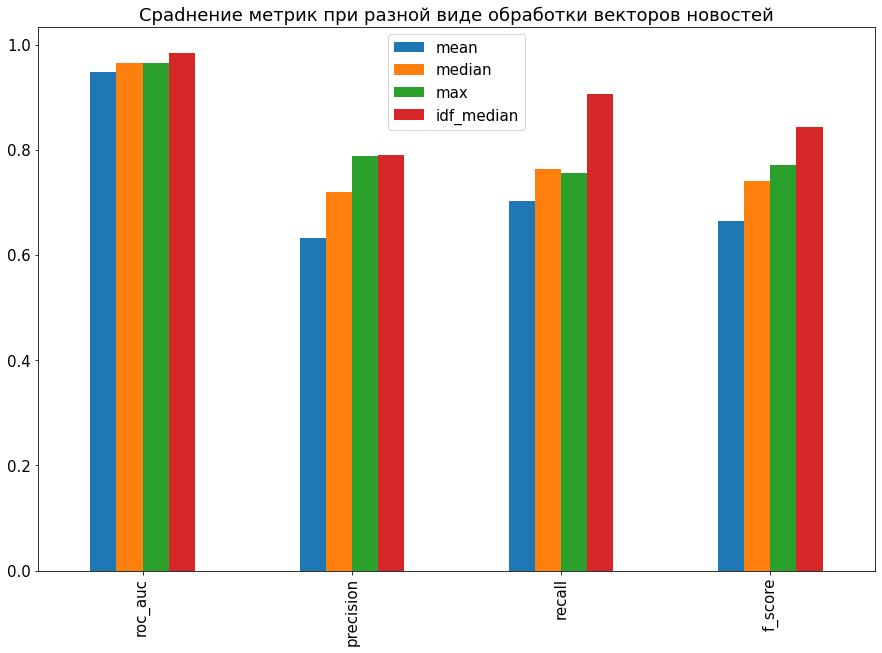

In [657]:
font = {'size' : 15}
plt.rc('font', **font)
metrics_df.plot(kind = 'bar', title='Сраdнение метрик при разной виде обработки векторов новостей', figsize=(15, 10))
plt.legend(loc ="best")
plt.show()

#### Выводы:
1. Мы видим, что при изменении способов объединения векторов новостей в функции get_user_embedding метрики стабильно растут
2. При замене способа со среднего на медиану рост метрик происходит благодаря тому, что происходит невелирование выбросов, к которым медиана менее чувствительна
3. При замене способа с медианы на максимальное значение рост происходит по-видимому благодаря тому, что мы получаем максимально выраженный вектор, у которого больше расстояние с другими векторами и поэтому он образает лучшей разделяющей способностью именно в данной соворумности векторов (с другими векторами ситуация может выглядеть иначе)
4. При использовании меnода взвешивания новостей путем перемножения их векторов на idf-вес, происходит снижение влияния на общий результат неважных новостей, которые всречаются у большинства читателей, и ,следовательно, не несут большой дигностической значимости 